In [1]:
"""
安装pySWATPlus
   SPOTPY
   mpi4py
   MS mpi

0、pySWATPlus 下载rar解压，用anaconda prompt界面cd到解压的文件夹，用pytohn setup.py install安装

一、TxtinoutReader
1.必须指定工作路径，否则工作路径会变成copy里的路径
2.必须使用绝对路径
3.网页教程的参数格式不对
4.改变参数，不指定行id时，用 None

二、FileReader
1.读取文件不指定index时，必须用None,不可省略
2.usecols省略的话，读取的df为空

三、定义SWAT函数给SPOTPY用时注意以下几点
1、SWAT模型的参数定义不要超过上下界，如(0, 1)用(0.001, 0.999)代替
2、用pySWATPlus定义函数给simulation用时，尽量把只修改一次文件的语句放函数外面
   例如， reader.set_beginning_and_end_year(2017, 2018)
         reader.set_warmup(1)
         reader.enable_object_in_print_prt("channel_sd", True, False, False, False)
   这些直接在root文件夹里手动改就行，不要写成代码，因为用mpiexec并行处理时，会导致文件被意想不到的修改

"""
%reset -f
import os
import pandas as pd
import numpy as np
import spotpy as sp
import shutil
import mpi4py
import sys
from pySWATPlus.TxtinoutReader import TxtinoutReader
from pySWATPlus.FileReader import FileReader
from matplotlib import pyplot as plt
from datetime import datetime
# cwd = "E:/SPOTPY-and-pySWATPlus"
cwd = "E:/4_CodeLearn/Python/SPOTPY-and-pySWATPlus"

# 用pySWATPlus定义huron_swat函数

In [2]:
def huron_swat(reader, params, tpl_params, copy_path, show_output=False, delete_copy=True):
    result = reader.copy_and_run(dir=copy_path,
                                 params=params,
                                 tpl_params=tpl_params,
                                 show_output=show_output
                                 )
    reader = FileReader(os.path.join(result, "basin_aqu_mon.txt"),
                        has_units = True,
                        index=None,
                        usecols=["mon", "day", "yr", "unit", "no3_lat"],
                        filter_by={"unit": 1}
                        )
    res = reader.df
    res["Date"] = pd.to_datetime(pd.DataFrame({"year": res["yr"],
                                               "month": res["mon"],
                                               "day": res["day"]}))
    res.drop(columns=["mon", "day", "yr", "unit"], inplace=True)
    if delete_copy:
        shutil.rmtree(result, ignore_errors=True)
    os.chdir(cwd) #改回当前路径
    return res

# 定义SPOTPY类

In [3]:
class spot_swat():
    def __init__(self, TxtInOut_abspath, copy_path, start_print, end_print,
                 prior=sp.parameter.Uniform, obj_func=None,
                 show_output=False, delete_copy=True):
        self.reader = TxtinoutReader(TxtInOut_abspath)
        self.copy_path = copy_path
        self.start = start_print
        self.end = end_print
        self.obj_func = obj_func
        self.show_output = show_output
        self.delete_copy = delete_copy
    
        self.params = [prior('alpha_bf', 0.0001, 0.9999), #0
                       prior('bf_max', 0.0001, 1.9999),
                       prior('dep_bot', 0.0001, 9.9999),
                       prior('dep_wt', 0.0001, 9.9999),
                       prior('flo_dist', 0.0001, 199.9999),
                       prior('flo_min', 0.0001, 49.9999),
                       prior('gw_flo', 0.0001, 1.9999),
                       prior('no3_n', 0.0001, 999.9999),
                       prior('rchg_dp', 0.0001, 0.9999),
                       prior('revap', 0.0201, 0.1999), #9
                       prior('revap_min', 0.0001, 49.9999),
                       prior('spec_yld', 0.0001, 0.4999),
                       prior('hl_no3n', 0.0001, 199.9999),
                       prior('cn_a', 30.0001, 69.9999),
                       prior('cn_b', 50.0001, 79.9999),
                       prior('cn_c', 70.0001, 89.9999),
                       prior('cn_d', 80.0001, 94.9999),
                       prior('can_max', 0.0001, 99.9999),
                       prior('cn3_swf', 0.0001, 0.9999),
                       prior('epco', 0.0001, 0.9999), #19
                       prior('esco', 0.0001, 0.9999),
                       prior('lat_ttime', 0.5001, 179.9999),
                       prior('latq_co', 0.0001, 0.9999),
                       prior('perco', 0.0001, 0.9999),
                       prior('pet_co', 0.7001, 1.2999),
                       prior('exp_co', 0.0001, 0.9999),
                       prior('fr_hum_act', 0.0001, 0.9999),
                       prior('hum_c_n', 8.0001, 11.9999),
                       prior('nitrate', 0.0001, 99.9999),
                       prior('ovn', 0.0101, 0.6999), #29
                       prior('denit_exp', 0.0001, 2.9999),
                       prior('denit_frac', 0.0001, 0.9999),
                       prior('evap_adj', 0.5001, 0.9999),
                       prior('lai_noevap', 0.0001, 9.9999),
                       prior('msk_co1', 0.0001, 9.9999),
                       prior('msk_co2', 0.0001, 9.9999),
                       prior('msk_x', 0.0001, 0.2999),
                       prior('n_fix_max', 1.0001, 19.9999),
                       prior('n_perc', 0.0001, 0.9999),
                       prior('n_uptake', 0.0001, 99.9999), #39
                       prior('nperco_lchtile', 0.0001, 0.9999),
                       prior('orgn_min', 0.0011, 0.0029),
                       prior('rsd_cover', 0.1001, 0.4999),
                       prior('rsd_decay', 0.0001, 0.0499),
                       prior('rsd_decomp', 0.0201, 0.0999),
                       prior('scoef', 0.0001, 0.9999),
                       prior('surq_exp', 1.0001, 2.9999),
                       prior('surq_lag', 1.0001, 23.9999),
                       prior('sw_init', 0.0001, 0.9999),
                       prior('cov50', 0.0001, 0.90), #49
                       prior('fall_tmp', -4.9999, 4.9999), 
                       prior('melt_max_min', 0.0001, 9.9999),
                       prior('melt_tmp', -4.9999, 4.9999),
                       prior('snow_h2o', 0.0001, 499.9999),
                       prior('snow_init', 0.0001, 999.9999),
                       prior('tmp_lag', 0.0001, 0.9999),
                       prior('dist', 7600.0001, 29999.9999),
                       prior('dp', 0.0001, 5999.9999),
                       prior('drain', 10.0001, 50.9999), 
                       prior('lag', 0.0001, 99.9999), #59
                       prior('lat_kast', 0.0101, 3.9999),
                       prior('pump', 0.0001, 9.9999),
                       prior('rad', 3.0001, 39.9999),
                       prior('t_fc', 0.0001, 99.9999),
                       prior('fert_5', 0.0001, 999.9999),
                       prior('fert_6', 0.0001, 999.9999),
                       prior('fert_7', 0.0001, 999.9999),
                       prior('rsd_init', 0.0001, 9999.9999),
                       prior('awc', 0.0001, 0.9999),
                       prior('soil_k', 0.0001, 1999.9999),
                       ]
    def parameters(self):
        return sp.parameter.generate(self.params)

    def simulation(self, vector):
        par = np.array(vector)
        params = {"aquifer.aqu":("name", [(None, 'alpha_bf', par[0]),
                                               (None, 'bf_max', par[1]),
                                               (None, 'dep_bot', par[2]),
                                               (None, 'dep_wt', par[3]),
                                               (None, 'flo_dist', par[4]),
                                               (None, 'flo_min', par[5]),
                                               (None, 'gw_flo', par[6]),
                                               (None, 'no3_n', par[7]),
                                               (None, 'rchg_dp', par[8]),
                                               (None, 'revap', par[9]),
                                               (None, 'revap_min', par[10]),
                                               (None, 'spec_yld', par[11]),
                                               (None, 'hl_no3n', par[12]),
                                               ],
                                      ),
                       "cntable.lum":("description", [(None,"cn_a", par[13]),
                                                      (None,"cn_b", par[14]),
                                                      (None,"cn_c", par[15]),
                                                      (None,"cn_d", par[16]),
                                                      ],
                                      ),
                       "hydrology.hyd":("name", [(None, 'can_max', par[17]),
                                                 (None, 'cn3_swf', par[18]),
                                                 (None, 'epco', par[19]),
                                                 (None, 'esco', par[20]),
                                                 (None, 'lat_ttime', par[21]),
                                                 (None, 'latq_co', par[22]),
                                                 (None, 'perco', par[23]),
                                                 (None, 'pet_co', par[24]),
                                                 ],
                                        ),
                  "nutrients.sol":("name", [(None, 'exp_co', par[25]),
                                            (None, 'fr_hum_act', par[26]),
                                            (None, 'hum_c_n', par[27]),
                                            (None, 'nitrate', par[28]),
                                            ],
                                   ),
                       "ovn_table.lum":("name", [(None, 'ovn_mean', par[29]),
                                                 (None, 'ovn_min', par[29]),
                                                 (None, 'ovn_max', par[29])
                                                 ],
                                        ),
                       "parameters.bsn":("igen", [(None, 'denit_exp', par[30]),
                                                  (None, 'denit_frac', par[31]),
                                                  (None, 'evap_adj', par[32]),
                                                  (None, 'lai_noevap', par[33]),
                                                  (None, 'msk_co1', par[34]),
                                                  (None, 'msk_co2', par[35]),
                                                  (None, 'msk_x', par[36]),
                                                  (None, 'n_fix_max', par[37]),
                                                  (None, 'n_perc', par[38]),
                                                  (None, 'n_uptake', par[39]),
                                                  (None, 'nperco_lchtile', par[40]),
                                                  (None, 'orgn_min', par[41]),
                                                  (None, 'rsd_cover', par[42]),
                                                  (None, 'rsd_decay', par[43]),
                                                  (None, 'rsd_decomp', par[44]),
                                                  (None, 'scoef', par[45]),
                                                  (None, 'surq_exp', par[46]),
                                                  (None, 'surq_lag', par[47]),
                                                  (None, 'sw_init', par[48]),
                                                  ],
                                         ),
                       "snow.sno":("name", [(None, 'cov50', par[49]),
                                            (None, 'fall_tmp', par[50]),
                                            (None, 'melt_max', par[51]),
                                            (None, 'melt_min', par[51]),
                                            (None, 'melt_tmp', par[52]),
                                            (None, 'snow_h2o', par[53]),
                                            (None, 'snow_init', par[54]),
                                            (None, 'tmp_lag', par[55]),
                                            ],
                                   ),
                       "tiledrain.str":("name", [(None, 'dist', par[56]),
                                                 (None, 'dp', par[57]),
                                                 (None, 'drain', par[58]),
                                                 (None, 'lag', par[59]),
                                                 (None, 'lat_ksat', par[60]),
                                                 (None, 'pump', par[61]),
                                                 (None, 'rad', par[62]),
                                                 (None, 't_fc', par[63]),
                                                 ],
                                        ),
                       
                       }
        tpl_params = {"management.sch.tpl": {"fert_5": par[64],
                                             "fert_6": par[65],
                                             "fert_7": par[66],
                                             },
                      "plant.ini.tpl": {"rsd_init": par[67]},
                      "soils.sol.tpl": {"awc": par[68],
                                        "soil_k": par[69]},
                      }
        sim = huron_swat(self.reader, params, tpl_params, self.copy_path,
                         show_output=self.show_output, delete_copy=self.delete_copy)
        return sim["no3_lat"]*90643.0
    
    def evaluation(self):
        obs = pd.read_csv(os.path.join(cwd,'TimeSeries\\monthly_load.csv'))
        obs["Date"] = pd.to_datetime(obs["Date"])
        obs = obs.loc[((obs["Date"] >= self.start) & (obs["Date"] <= self.end)),("Load_COND_min", "Load_COND_max")]
        return obs
    def objectivefunction(self, simulation, evaluation):
        if not self.obj_func:
            like = sp.objectivefunctions.nashsutcliffe(evaluation, simulation)
        else:
            like = self.obj_func(evaluation, simulation)
        return like
    

# 参数率定

In [4]:
# 源文件路径和复制文件路径
proj_path = os.path.join(cwd, "Cal_TxtInOut")
copy_path = os.path.join(cwd, "Cal_copy")

# 设置SWAT模拟时间范围
start_sim = "2017-01-01"
end_sim = "2020-12-31"

# 设置SWAT输出时间范围
start_print = "2018-01-01"
end_print = "2020-12-31"
warmup = 1

# 输出选项
show_output = True
delete_copy = False

# 目标函数
def obj_func(evaluation, simulation):
    e = np.where(simulation < evaluation.iloc[:, 0],
                 evaluation.iloc[:, 0] - simulation,
                 np.where(simulation > evaluation.iloc[:, 1],
                          evaluation.iloc[:, 1] - simulation,
                          0)
                 )
    return -np.sqrt(np.mean(e**2))

# 实例化及采样
spot_setup = spot_swat(proj_path, copy_path, start_print, end_print, obj_func=obj_func,
                       show_output=show_output, delete_copy=delete_copy)

spot_setup.reader.set_simulation_time(start_sim, end_sim)
spot_setup.reader.set_print_time(start_print, end_print, warmup)
spot_setup.reader.enable_object_in_print_prt("basin_aqu", False, True, False, False)
sampler = sp.algorithms.mc(spot_setup,
                           dbname="Cal", 
                           dbformat="csv",
                           # parallel="mpi",
                           )
# sampler.sample(repetitions=1,
#                # percentage_first_run=0.3,
#                # percentage_following_runs=0.3
#                # ngs=10,
#                )

# Best sim

Run number 495 has the highest objectivefunction with: -13387.96


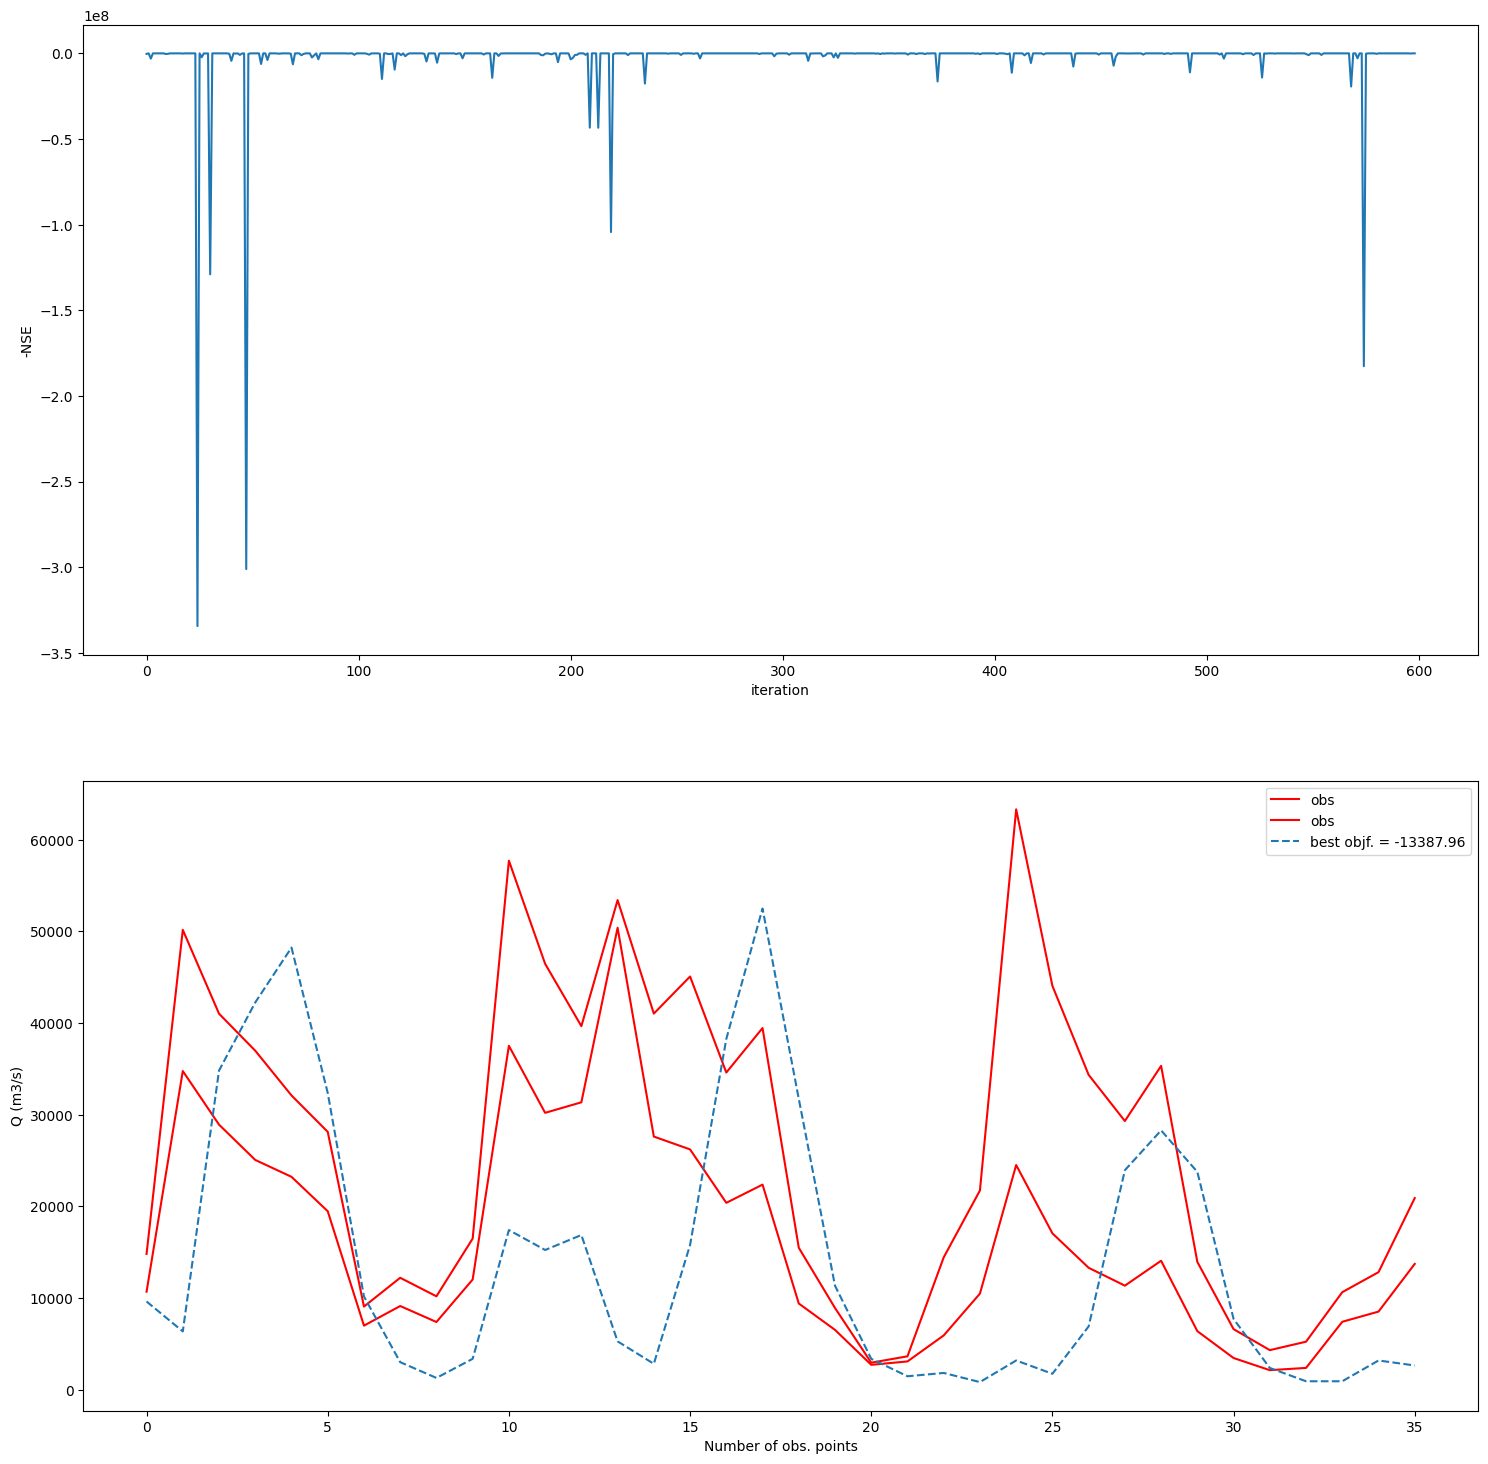

In [6]:
Cal_results = sp.analyser.load_csv_results("Cal")
bestindex, bestobjf = sp.analyser.get_maxlikeindex(Cal_results)
bestindex = 495
best_model_run = Cal_results[bestindex]
fields = [word for word in best_model_run.dtype.names if word.startswith("sim")]
best_simulation = np.array(list(best_model_run[fields]))
obs = np.array(spot_setup.evaluation())

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18,18))
ax1.plot(Cal_results['like1'])
ax1.set_xlabel("iteration")
ax1.set_ylabel("-NSE")

ax2.plot(obs, "r-", label="obs")
ax2.plot(best_simulation, "--", markersize = 2 ,label="best objf. = " + str(bestobjf))
ax2.set_xlabel("Number of obs. points")
ax2.set_ylabel("Q (m3/s)")
ax2.legend()

# Bayseian

In [12]:
obs = np.array(spot_setup.evaluation())
likes = np.array([0, 1, 2, 3, 4,5,6,6,6,6,6,6])
# likes = np.arange(12)
z = sorted(zip(likes, obs), key=lambda x:x[0])
z[2:5]

[(2, array([28903.63021, 41007.6345 ])),
 (3, array([25052.07697, 36969.57586])),
 (4, array([23210.81715, 32089.20028]))]